# Boltz Generalized Covalent Residue Modification

Modifies the Boltz Chemical Component Dictionary cache with a new entry corresponding to an arbitrary covalent modification of a residue.

___
<I>Benjamin Fry (bfry@g.harvard.edu)</I>

In [26]:
from rdkit import Chem
from rdkit.Chem import AllChem

import pickle
from pathlib import Path

# THIS IS ABSOLUTELY NECESSARY TO MAKE SURE THAT ALL PROPERTIES ARE PICKLED OR ELSE BOLTZ WILL CRASH.
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

In [27]:
ncaa_smiles_str = "CC(C)(N)C(=O)O"  # SMILES for Aib
reference_residue_to_modify = 'ALA'  # Using ALA instead of CYS
output_ccd_code = "XAIB"  # Custom code for Aib

### Load the Boltz Cache Chemical Component Dictionary

In [28]:
cache_dir = Path("~/.boltz/").expanduser()

# Verify the path exists and has ccd.pkl
assert cache_dir.exists(), f"Cache directory {cache_dir} does not exist"
assert (cache_dir / 'ccd.pkl').exists(), f"CCD file {cache_dir / 'ccd.pkl'} does not exist"

ccd_path = cache_dir / 'ccd.pkl'
with ccd_path.open("rb") as file:
    ccd = pickle.load(file)  # noqa: S301

### Visualize molecule and atom indices for sanity check

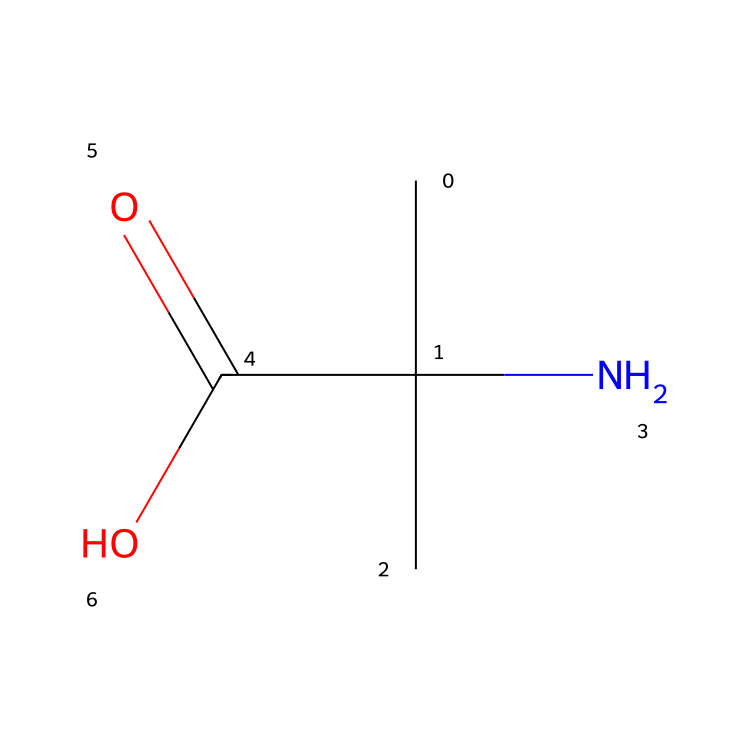

In [29]:
# Create drawing options with atom indices 
smiles_mol = Chem.MolFromSmiles(ncaa_smiles_str)
draw_options = Chem.Draw.MolDrawOptions()
draw_options.addAtomIndices = True  # Enable atom indices to be displayed

# Increase size of displayed image
import IPython.display
IPython.display.display(Chem.Draw.MolToImage(smiles_mol, size=(750, 750), options=draw_options))

In [30]:
# Load Alanine from the CCD and remove hydrogens
ala_mol = ccd[reference_residue_to_modify]  # This should be loading ALA now
reference_ala_mol = AllChem.RemoveHs(ala_mol)

# Debug: Print molecules info
print("Alanine atoms:", [atom.GetSymbol() for atom in reference_ala_mol.GetAtoms()])
print("Aib atoms:", [atom.GetSymbol() for atom in smiles_mol.GetAtoms()])

# Search for the alanine substructure in the Aib molecule
has_match = smiles_mol.HasSubstructMatch(reference_ala_mol)
print("Has match:", has_match)

if has_match:
    match_indices = smiles_mol.GetSubstructMatch(reference_ala_mol)
    substruct_to_match = {i.GetProp('name'): match_indices[idx] for idx, i in enumerate(reference_ala_mol.GetAtoms())}
else:
    print("No substructure match found!")
    print("Reference residue used:", reference_residue_to_modify)
    # Initialize empty mapping if no match found
    substruct_to_match = {}

# Construct mapping of alanine atom name to atom index in the ncaa molecule
idx_to_name = {j: i for i, j in substruct_to_match.items()}
print("Mapping:", idx_to_name)

Alanine atoms: ['N', 'C', 'C', 'O', 'C', 'O']
Aib atoms: ['C', 'C', 'C', 'N', 'C', 'O', 'O']
Has match: True
Mapping: {3: 'N', 1: 'CA', 4: 'C', 5: 'O', 0: 'CB', 6: 'OXT'}


### Add the metadata boltz expects to the atoms

In [31]:
for idx, atom in enumerate(smiles_mol.GetAtoms()):
    # Define OXT atom
    default_name = f'{atom.GetSymbol()}{str(atom.GetIdx())}'

    # If the index is a canonical cysteine atom, use the cysteine atom name
    name = idx_to_name.get(idx, default_name)

    # Set atom properties
    atom.SetProp('name', name)
    atom.SetProp('alt_name', name) 
    is_leaving = False
    if name == 'OXT':
        is_leaving = True
    atom.SetBoolProp('leaving_atom', is_leaving)

### Reorder atoms to canonical ordering (N, Ca, C, O, CB, S, ...)

In [32]:
# Map atom name to atom index in the ncaa molecule 
curr_atom_order = {atom.GetProp('name'): idx for idx, atom in enumerate(smiles_mol.GetAtoms()) if atom.GetSymbol() != 'H'}

# Map atom name to atom index in the reference cysteine molecule
target_atom_order = {}
for atom in reference_ala_mol.GetAtoms():
    if atom.GetSymbol() == 'H':
        continue
    target_atom_order[atom.GetProp('name')] = atom.GetIdx()

# There are atoms not in target_atom_order that are in curr_atom_order so we need to these
remapped_atom_order = {}
offset_idx = len(target_atom_order)
for atom in curr_atom_order:
    if atom in target_atom_order:
        remapped_atom_order[atom] = target_atom_order[atom]
    else:
        remapped_atom_order[atom] = offset_idx
        offset_idx += 1

# Remove hydrogens and reorder atoms according to the order in the reference cysteine.
trim = AllChem.RemoveHs(smiles_mol)
remap_order = {x.GetProp('name'): (remapped_atom_order[x.GetProp('name')], x.GetIdx()) for x in trim.GetAtoms()}
remap_idx_list = [x[1] for x in sorted(remap_order.values())]
trim_reordered = Chem.RenumberAtoms(trim, remap_idx_list)

### Generate a conformer, could make this more sophisticated...

In [33]:
# Generate a simple conformer, might want to do something more sophisticated or start with a DFT conformer in an SDF file.
trim_reordered = AllChem.AddHs(trim_reordered)
AllChem.EmbedMolecule(trim_reordered)
AllChem.UFFOptimizeMolecule(trim_reordered)

# Set conformer properties
for c in trim_reordered.GetConformers():
    c.SetProp('name', 'Ideal')

### Sanity check renumbering was successful.

In [34]:
for atom in trim_reordered.GetAtoms():
    if atom.GetSymbol() == 'H':
        continue
    print(atom.GetIdx(), atom.GetPropsAsDict())

0 {'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x1818d9440>, 'name': 'N', 'alt_name': 'N', 'leaving_atom': False}
1 {'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x1818d9440>, 'name': 'CA', 'alt_name': 'CA', 'leaving_atom': False}
2 {'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x1818d9440>, 'name': 'C', 'alt_name': 'C', 'leaving_atom': False}
3 {'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x1818d9440>, 'name': 'O', 'alt_name': 'O', 'leaving_atom': False}
4 {'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x1818d9440>, 'name': 'CB', 'alt_name': 'CB', 'leaving_atom': False}
5 {'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9all

### Save the conformer to the ccd cache and overwrite it.

In [35]:
ccd[output_ccd_code] = trim_reordered

ccd_path = cache_dir / 'ccd.pkl'
with ccd_path.open("wb") as file:
    pickle.dump(ccd, file)

### To Run Inference:
Run `boltz predict ./path_to_yaml_file` with the following yaml file contents to test the custom modification at residue 2:
___


```yaml
version: 1  # Optional, defaults to 1
sequences:
  - protein:
      id: [A]
      sequence: AAAAACAAAAAAAAAAA # This doesn't have to have a CYS at position 6 to apply the modification, but it does in this case.
      msa: empty
      modifications:
        - position: 6 
          ccd: 'CUSTOM' # Use the custom CCD code we just injected.
```